In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import terratorch
import torch
import torchgeo 
import tqdm as notebook_tqdm
import json

#import geopandas as gpd
import pandas as pd

import sys
sys.path.append('../')


import utils.basics as bsc
import utils.plotting as pt
import utils.eval as eval

import importlib
importlib.reload(pt)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/Users/felix/miniconda3/envs/CHM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load the data

In [2]:
# === Paths ===
#INPUT_FOLDER = "../data/03_training"
INPUT_FOLDER = "../data/03_training/32_withNaN"

ALS1_NORM_PARAMS = '../data/02_processed/ALS_norm_params_Site1_Ebrach.json'
ALS2_NORM_PARAMS = '../data/02_processed/ALS_norm_params_Site2_Waldbrunn.json'
ALS_NORM_PARAMS_JOINT = '../data/02_processed/ALS_norm_params_joint.json'


1. load all patches; we say 70% train; 15% val; 15% test
2. handle both sites
    1. merge; train/test/val contains same amount of data share per site
    2. separate; take one site for training, the other for testing.

In [3]:
def load_and_split_patches(site, patch_size=32, test_size=0.3, random_state=42, use_fmask=True, normalize_als=False, s2_band_indices=None):
    """
    Load S2 and ALS patches for a given site, split into train/test sets.
    Optionally normalize ALS patches for training.
    Optionally select specific S2 bands.

    Parameters:
    - site: int (1 or 2)
    - patch_size: int
    - test_size: float
    - random_state: int
    - normalize_als: bool
    - s2_band_indices: list or np.ndarray of int, optional (default: all bands)

    Returns:
    - X_train, X_test, y_train, y_test, als_mean, als_std (mean/std are None if not normalized)
    """
    s2_patches = np.load(os.path.join(INPUT_FOLDER, f"S2_site{site}_px{patch_size}.npy"))
    als_patches = np.load(os.path.join(INPUT_FOLDER, f"ALS_site{site}_px{patch_size}.npy"))
    fmask_patches = np.load(os.path.join(INPUT_FOLDER, f"FMASK_site{site}_px{patch_size}.npy"))

    if use_fmask:
        # stack fmask as the last channel to the S2 patches
        fmask_patches = fmask_patches[:, np.newaxis, :, :]  # add channel dimension
        s2_patches = np.concatenate((s2_patches, fmask_patches), axis=1)

    #print(f"Site {site}: Loaded S2 patches shape: {s2_patches.shape}, ALS patches shape: {als_patches.shape}, Fmask patches shape: {fmask_patches.shape}")
    
    if s2_band_indices is not None:
        s2_patches = s2_patches[:, s2_band_indices, :, :]

    #X_train, X_test, y_train, y_test = train_test_split(s2_patches, als_patches, test_size=test_size, random_state=random_state)
    
    # split to train, validation, and test sets
    # 70% train, 15% validation, 15% test
    X_train, X_test, y_train, y_test = train_test_split(s2_patches, als_patches, test_size=test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

    als_mean, als_std = None, None
    if normalize_als:
        als_mean = y_train.mean()
        als_std = y_train.std()
        y_train = (y_train - als_mean) / (als_std + 1e-8)
        y_test = (y_test - als_mean) / (als_std + 1e-8)
        print(f"ALS normalization: mean={als_mean:.4f}, std={als_std:.4f}")

    print(f"Site {site}: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Site {site}: X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"Site {site}: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Example usage with all bands (default)
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = load_and_split_patches(site=1, normalize_als=False)
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = load_and_split_patches(site=2, normalize_als=False)

print(f"Total train patches (site 1 + 2): \t{len(X_train1) + len(X_train2)}.\n"
      f"Total val patches (site 1 + 2): \t{len(X_val1) + len(X_val2)}.\n"
      f"Total test patches (site 1 + 2): \t{len(X_test1) + len(X_test2)}. ")
# Example usage with selected bands, e.g. bands 0, 1, 2
# X_train1, X_test1, y_train1, y_test1, als_mean1, als_std1 = load_and_split_patches(site=1, normalize_als=True, s2_band_indices=[0,1,2])

Site 1: X_train shape: (308, 14, 32, 32), y_train shape: (308, 32, 32)
Site 1: X_val shape: (66, 14, 32, 32), y_val shape: (66, 32, 32)
Site 1: X_test shape: (67, 14, 32, 32), y_test shape: (67, 32, 32)
Site 2: X_train shape: (268, 14, 32, 32), y_train shape: (268, 32, 32)
Site 2: X_val shape: (57, 14, 32, 32), y_val shape: (57, 32, 32)
Site 2: X_test shape: (58, 14, 32, 32), y_test shape: (58, 32, 32)
Total train patches (site 1 + 2): 	576.
Total val patches (site 1 + 2): 	123.
Total test patches (site 1 + 2): 	125. 


In [71]:
# Reshape to (308*32*32,) and calculate mean and std ignoring NaNs
mean = np.nanmean(y_train1.reshape(-1))
std = np.nanstd(y_train1.reshape(-1))
print("Mean:", mean)
print("Std:", std)

Mean: -0.39332205
Std: 1.6832492


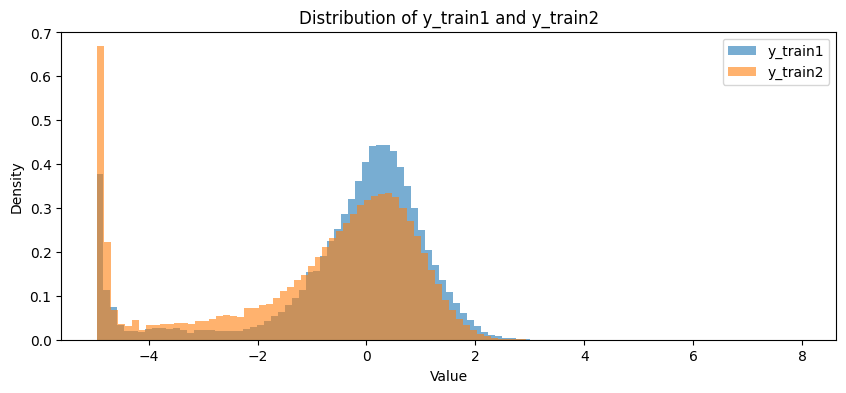

y_train1: mean=-0.3933, std=1.6832
y_train2: mean=-0.9435, std=1.9400
y_train:  mean=-0.6488, std=1.8277
y_val1:   mean=-0.3331, std=1.5923
y_val2:   mean=-0.7762, std=1.7827
y_val:    mean=-0.5380, std=1.6975
y_test2:  mean=-1.2245, std=2.1030
JOINT:    mean=-0.6688, std=1.8392


In [82]:
plt.figure(figsize=(10, 4))
plt.hist(y_train1.flatten(), bins=100, alpha=0.6, label='y_train1', density=True)
plt.hist(y_train2.flatten(), bins=100, alpha=0.6, label='y_train2', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of y_train1 and y_train2')
plt.show()
# Calculate mean and std for each array
mean_y_train1 = np.nanmean(y_train1)
std_y_train1 = np.nanstd(y_train1)
mean_y_train2 = np.nanmean(y_train2)
std_y_train2 = np.nanstd(y_train2)
mean_y_train = np.nanmean(y_train)
std_y_train = np.nanstd(y_train)
mean_y_val1 = np.nanmean(y_val1)
std_y_val1 = np.nanstd(y_val1)
mean_y_val2 = np.nanmean(y_val2)
std_y_val2 = np.nanstd(y_val2)
mean_y_val = np.nanmean(y_val)
std_y_val = np.nanstd(y_val)
mean_y_test2 = np.nanmean(y_test2)
std_y_test2 = np.nanstd(y_test2)

# Joint mean and std for all arrays together
all_values = np.concatenate([
    y_train1.flatten(), y_train2.flatten(),
    y_val1.flatten(), y_val2.flatten(),
    y_test1.flatten(), y_test2.flatten()
])
joint_mean = np.nanmean(all_values)
joint_std = np.nanstd(all_values)

print(f"y_train1: mean={mean_y_train1:.4f}, std={std_y_train1:.4f}")
print(f"y_train2: mean={mean_y_train2:.4f}, std={std_y_train2:.4f}")
print(f"y_train:  mean={mean_y_train:.4f}, std={std_y_train:.4f}")
print(f"y_val1:   mean={mean_y_val1:.4f}, std={std_y_val1:.4f}")
print(f"y_val2:   mean={mean_y_val2:.4f}, std={std_y_val2:.4f}")
print(f"y_val:    mean={mean_y_val:.4f}, std={std_y_val:.4f}")
print(f"y_test2:  mean={mean_y_test2:.4f}, std={std_y_test2:.4f}")
print(f"JOINT:    mean={joint_mean:.4f}, std={joint_std:.4f}")


## lets customize site vs. train/val/test stacking
objective: stack partial sites to custom train/val/test parts

In [81]:
# write a function that stacks the training, validation, and test sets for both sites
def merge_datasets(X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
                   X_train2, X_val2, X_test2, y_train2, y_val2, y_test2):
    """
    Stack training, validation, and test sets for both sites.

    Parameters:
    - X_train1, X_val1, X_test1, y_train1, y_val1, y_test1: Site 1 datasets
    - X_train2, X_val2, X_test2, y_train2, y_val2, y_test2: Site 2 datasets

    Returns:
    - Stacked training, validation, and test sets
    """
    X_train = np.vstack((X_train1, X_train2))
    X_val = np.vstack((X_val1, X_val2))
    X_test = np.vstack((X_test1, X_test2))
    y_train = np.vstack((y_train1, y_train2))
    y_val = np.vstack((y_val1, y_val2))
    y_test = np.vstack((y_test1, y_test2))

    print("We merge both sites into one training, validation, and test set.")

    print(f"Stacked X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Stacked X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"Stacked X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Merge datasets
X_train, X_val, X_test, y_train, y_val, y_test = merge_datasets(
    X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
    X_train2, X_val2, X_test2, y_train2, y_val2, y_test2
)

We merge both sites into one training, validation, and test set.
Stacked X_train shape: (576, 14, 32, 32), y_train shape: (576, 32, 32)
Stacked X_val shape: (123, 14, 32, 32), y_val shape: (123, 32, 32)
Stacked X_test shape: (125, 14, 32, 32), y_test shape: (125, 32, 32)


In [12]:
def separate_datasets(X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
                        X_train2, X_val2, X_test2, y_train2, y_val2, y_test2, trainsite=1):
    """
    Train / validation from one site and testing from the other site.

    Parameters:
    - X_train1, X_val1, X_test1, y_train1, y_val1, y_test1: Site 1 datasets
    - X_train2, X_val2, X_test2, y_train2, y_val2, y_test2: Site 2 datasets

    Returns:
    - Stacked training, validation, and test sets
    """
    # Train : Site 1 Train
    # Val : Site 1 Val + Site 1 Test
    # Test: Site 2 Train + Site 2 Val + Site 2 Test

    if trainsite == 1:
        # Site 1 for training and validation, Site 2 for testing
        X_train = X_train1
        X_val = np.vstack((X_val1, X_test1))
        y_train = y_train1
        y_val = np.vstack((y_val1, y_test1))
        # Use Site 2 for testing
        X_test = np.vstack((X_train2, X_val2, X_test2))
        y_test = np.vstack((y_train2, y_val2, y_test2))
    elif trainsite == 2:
        # Site 2 for training and validation, Site 1 for testing
        X_train = X_train2
        X_val = np.vstack((X_val2, X_test2))
        y_train = y_train2
        y_val = np.vstack((y_val2, y_test2))
        # Use Site 1 for testing
        X_test = np.vstack((X_train1, X_val1, X_test1))
        y_test = np.vstack((y_train1, y_val1, y_test1))

    print(f"We use Site {trainsite} for training and validation and test on Site {3 - trainsite}.") 
    print(f"Stacked X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Stacked X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"Stacked X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
if False:
    X_train, X_val, X_test, y_train, y_val, y_test = separate_datasets(
        X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
        X_train2, X_val2, X_test2, y_train2, y_val2, y_test2
    )

### sequential learning
1. train with site 1
2. use same model, retrain with site 2
--> does it get any better? 

In [5]:
pretrainmode = False
finetrainmode = False #not(pretrainmode)

if pretrainmode:
    # first iteration
    #X_train, X_val, X_test, y_train, y_val, y_test = X_train1, X_val1, X_test1, y_train1, y_val1, y_test1
    X_train, X_val, X_test, y_train, y_val, y_test = X_train2, X_val2, X_test2, y_train2, y_val2, y_test2
else:
    # second iteration
    #X_train, X_val, X_test, y_train, y_val, y_test = X_train2, X_val2, X_test2, y_train2, y_val2, y_test2
    X_train, X_val, X_test, y_train, y_val, y_test = X_train1, X_val1, X_test1, y_train1, y_val1, y_test1


## sketch the U-Net architecture. 

In [ ]:
# Central hyperparameter config as default

config = {
    'patch_size': 32,
    'num_bands': 15,        # change based on input (13+1 for fmask, +1 for mask channel)
    'batch_size': 64,
    'lr': 1e-3,
    'weight_decay': 3e-4,
    'momentum': 0.9,
    'epochs': 250,
    'huber_delta': 1,
    'device':  'mps' if torch.backends.mps.is_available() else 'cpu'
}

In [89]:
class S2CanopyHeightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()               # (N, num_bands, 32, 32)
        self.y = torch.from_numpy(y).float().unsqueeze(1)  # (N, 1, 32, 32)
        # NaN mask across bands → shape: (N, 1, 32, 32)
        # A pixel is valid if *not all bands* in X are NaN and y is not NaN
        x_valid = ~torch.isnan(self.X).any(dim=1, keepdim=True)  # (N, num_bands, 32, 32)
        y_valid = ~torch.isnan(self.y)                           # (N, 1, 32, 32)
        self.mask = x_valid & y_valid

        # Replace NaNs in input with -1.0 or some other value
        self.X[torch.isnan(self.X)] = -1.0 
        self.y[torch.isnan(self.y)] = -1.0 
    def __len__(self):
        return self.X.shape[0]
    # def __getitem__(self, idx):
    #     return self.X[idx], self.y[idx]
    def __getitem__(self, idx):
        x = self.X[idx]                         # (num_bands, 32, 32)
        m = self.mask[idx].float()             # (1, 32, 32)
        x_with_mask = torch.cat([x, m], dim=0) # (num_bands + 1, 32, 32)
        return x_with_mask, self.y[idx], self.mask[idx]  # keep mask for loss too
    def __getstats__(self):
        """
        Returns the mean and std of the dataset.
        """
        # Calculate mean and std only for valid (non-NaN) areas using the mask
        valid_y = self.y[self.mask]
        mean = torch.mean(valid_y)
        std = torch.std(valid_y)
        return mean.item(), std.item()
    def __getdistr__(self):
        """
        Returns the distribution of the dataset.
        """
        # Calculate distribution of valid (non-NaN) areas using the mask
        valid_y = self.y[self.mask].flatten()
        hist, bin_edges = np.histogram(valid_y.cpu().numpy(), bins=100, density=True)
        return hist, bin_edges

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = S2CanopyHeightDataset(X_train, y_train)
val_dataset = S2CanopyHeightDataset(X_val, y_val)
test_dataset = S2CanopyHeightDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels=1, dropout=0.2):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(dropout),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(dropout)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.decoder2(torch.cat([self.upconv2(bottleneck), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        return self.final(dec1)

# For debugging: set mask to all ones to match nn.HuberLoss behavior
def masked_huber_loss(pred, target, mask, delta=config['huber_delta']):
    """
    Computes the masked Huber loss (Smooth L1 loss).
    If mask is all ones, this should match nn.HuberLoss.
    """
    # Uncomment the next line to force mask to all ones for testing
    #mask = torch.ones_like(target)
    mask = mask.float()
    error = pred - target
    abs_error = torch.abs(error)

    quadratic = torch.minimum(abs_error, torch.tensor(delta, device=pred.device))
    linear = abs_error - quadratic

    loss = 0.5 * quadratic**2 + delta * linear
    masked_loss = loss * mask

    return masked_loss.sum() / mask.sum().clamp(min=1)


### new loss functions

In [8]:
import torch.nn.functional as F

def edge_sensitive_huber_loss(pred, target, mask, delta=config['huber_delta'], edge_weight=2.0):
    """
    Edge-sensitive masked Huber loss.
    Errors at edges (in target) are weighted higher.
    """
    # Compute Sobel edges on target
    sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=target.dtype, device=target.device).view(1,1,3,3)
    sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=target.dtype, device=target.device).view(1,1,3,3)
    # target: (N, 1, H, W)
    edge_x = F.conv2d(target, sobel_x, padding=1)
    edge_y = F.conv2d(target, sobel_y, padding=1)
    edge_mag = torch.sqrt(edge_x**2 + edge_y**2)
    # Normalize edge magnitude to [0,1]
    edge_mask = (edge_mag > edge_mag.mean()).float()
    # Weight: edge_weight at edges, 1 elsewhere
    weights = 1.0 + (edge_weight - 1.0) * edge_mask

    # Standard masked Huber loss
    mask = mask.float()
    error = pred - target
    abs_error = torch.abs(error)
    quadratic = torch.minimum(abs_error, torch.tensor(delta, device=pred.device))
    linear = abs_error - quadratic
    loss = 0.5 * quadratic**2 + delta * linear

    # Apply edge weights and mask
    weighted_loss = loss * weights * mask
    return weighted_loss.sum() / (weights * mask).sum().clamp(min=1)


In [96]:
def frequency_weighted_huber_loss(pred, target, mask, hist, bin_edges, delta=config['huber_delta'], max_weight=10.0, tail_factor=2.0):
    """
    Masked Huber loss with frequency-based reweighting using a histogram.
    Each pixel is weighted by the inverse frequency of its target value in the training set.
    """
    # Flatten target and mask
    target_flat = target.view(-1)
    mask_flat = mask.view(-1).float()

    # Digitize target values to histogram bins
    bin_indices = np.digitize(target_flat.cpu().numpy(), bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, len(hist) - 1)
    # Get frequency for each target value
    freq = hist[bin_indices].astype(np.float32)
    freq = torch.from_numpy(freq).to(target.device).float()

    # Inverse frequency as weight, upweighting rare values
    weights = (1.0 / (freq + 1e-8)) ** tail_factor
    weights = weights / weights.mean()
    weights = torch.clamp(weights, max=max_weight)

    # Standard masked Huber loss
    error = pred.view(-1) - target_flat
    abs_error = torch.abs(error)
    quadratic = torch.minimum(abs_error, torch.tensor(delta, device=pred.device))
    linear = abs_error - quadratic
    loss = 0.5 * quadratic**2 + delta * linear

    # Apply weights and mask
    weighted_loss = loss * weights * mask_flat
    return weighted_loss.sum() / (weights * mask_flat).sum().clamp(min=1)


## edge sensitive loss

### training edge sensitive

In [ ]:
!pip install optuna --quiet
import optuna

def objective(trial):
    # Suggest hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [64])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    momentum = trial.suggest_float('momentum', 0.6, 0.99)
    huber_delta = trial.suggest_float('huber_delta', 0.7, 1.0)
    edge_weight = trial.suggest_float('edge_weight', 1.0, 3.0)

    # Update config
    config.update({
        'batch_size': batch_size,
        'lr': lr,
        'weight_decay': weight_decay,
        'momentum': momentum,
        'huber_delta': huber_delta,
        'edge_weight': edge_weight
    })

    # Re-create loaders with new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Model, optimizer, loss
    model = UNet(config['num_bands']).to(config['device'])
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = edge_sensitive_huber_loss

    # Training loop (short for tuning)
    epochs = 35
    for epoch in range(epochs):
        model.train()
        for inputs, targets, mask in train_loader:
            inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets, mask, delta=huber_delta, edge_weight=edge_weight)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets, mask in val_loader:
                inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
                outputs = model(inputs)
                loss = criterion(outputs, targets, mask, delta=huber_delta, edge_weight=edge_weight)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=75)

print("Best parameters:")
print(study.best_params)
print(f"Best validation loss: {study.best_value:.4f}")

# Overview of all trials
df_trials = study.trials_dataframe()
df_trials = df_trials.sort_values('value', ascending=True)
df_trials.head()
#print(df_trials[['batch_size', 'lr', 'weight_decay', 'momentum', 'huber_delta', 'value']].sort_values('value'))

[I 2025-07-22 14:26:03,622] A new study created in memory with name: no-name-b3189326-edbb-4fda-b1b2-06151d4fdf0e
[W 2025-07-22 14:26:03,916] Trial 0 failed with parameters: {'batch_size': 64, 'lr': 0.0009011378451682773, 'weight_decay': 0.00011128563642915314, 'momentum': 0.8769774821055069, 'huber_delta': 0.974388477188572, 'edge_weight': 1.8108749101030286} because of the following error: TypeError("edge_sensitive_huber_loss() got an unexpected keyword argument 'hist'").
Traceback (most recent call last):
  File "/Users/felix/miniconda3/envs/CHM/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/0s/1cgzkm553c3gm9c4dkbzdh680000gn/T/ipykernel_6176/2898339331.py", line 41, in objective
    loss = criterion(outputs, targets, mask, hist=hist, bin_edges=bin_edges, delta=huber_delta, edge_weight=edge_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

TypeError: edge_sensitive_huber_loss() got an unexpected keyword argument 'hist'

In [11]:
print(study.best_params)

{'batch_size': 32, 'lr': 0.00091655213908832, 'weight_decay': 0.0005772134892280867, 'momentum': 0.775752383906955, 'huber_delta': 0.7116172638262825}


In [21]:
#df_trials sort descending by value
df_trials = df_trials.sort_values('value', ascending=True)
df_trials.head()
# Print the relevant columns    
#print(df_trials[['params_batch_size', 'params_lr', 'params_weight_decay', 'params_momentum', 'params_huber_delta', 'value']].sort_values('value', ascending=True))

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_edge_weight,params_huber_delta,params_lr,params_momentum,params_weight_decay,state
71,71,0.289874,2025-07-22 11:35:35.898013,2025-07-22 11:35:44.967853,0 days 00:00:09.069840,64,1.002503,0.720810,0.001764,0.934201,0.000107,COMPLETE
73,73,0.291560,2025-07-22 11:35:54.147493,2025-07-22 11:36:03.462538,0 days 00:00:09.315045,64,1.166029,0.724178,0.001451,0.989227,0.000089,COMPLETE
72,72,0.304917,2025-07-22 11:35:44.968353,2025-07-22 11:35:54.146752,0 days 00:00:09.178399,64,1.226221,0.723195,0.001372,0.985796,0.000087,COMPLETE
2,2,0.313968,2025-07-22 11:33:55.660194,2025-07-22 11:34:04.825353,0 days 00:00:09.165159,64,1.731909,0.709728,0.001193,0.841198,0.000395,COMPLETE
41,41,0.318815,2025-07-22 11:35:10.264959,2025-07-22 11:35:19.430508,0 days 00:00:09.165549,64,2.055712,0.728484,0.001160,0.894612,0.000474,COMPLETE


In [22]:

# Central hyperparameter config
finetrainmode = False # not(pretrainmode)
config = {
    'patch_size': 32,
    'num_bands': 15,        # change based on input (13+1 for fmask, +1 for mask channel)
    'batch_size': 64,
    'lr': 1e-3,
    'weight_decay': 3e-4,
    'momentum': 0.9,
    'epochs': 250,
    'huber_delta': 1,
    'device':  'mps' if torch.backends.mps.is_available() else 'cpu'
}

config.update(study.best_params)

model = UNet(config['num_bands']).to(config['device']) 
# load pretrained model if available as initialization
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

if finetrainmode:

    print("Finetuning mode: Loading pretrained model...")

    PRETRAINED_MODEL_PATH = '../models/unet_7_pretrain.pth'
    #model.load_state_dict(torch.load(PRETRAINED_MODEL_PATH, map_location=config['device']))
    pretrained_dict = torch.load(PRETRAINED_MODEL_PATH, map_location=config['device'])
    model_dict = model.state_dict()

    # Filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

    # Overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 

    # Load the new state dict
    model.load_state_dict(model_dict)


criterion_nomask = nn.HuberLoss(delta=config['huber_delta'])
criterion = masked_huber_loss  # Use custom masked Huber loss
# criterion = nn.MSELoss()  # or nn.L1Loss() for Mean Absolute
# Learning rate scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

train_losses, val_losses = [], []
nancounts = 0

for epoch in trange(config['epochs'], desc="Epochs"):
    model.train()
    train_loss = 0.0
    for inputs, targets, mask in train_loader:
        inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets, mask)
        loss.backward()
        #loss_nomask = criterion_nomask(outputs,targets)
        #if abs(loss-loss_nomask)>1e-3: print("Error in Loss Function, unless nan input fed in.")
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        # Count number of zeros in the mask tensor for this batch
        nancounts += (mask == 0).sum().item()

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, mask in val_loader:
            inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
            outputs = model(inputs)
            loss = criterion(outputs, targets, mask)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if (epoch + 1) % 10 == 0 or epoch == config['epochs'] - 1:
        continue
        #print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        #print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    #print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
print("nancounts: ",nancounts)


Epochs: 100%|██████████| 250/250 [01:07<00:00,  3.71it/s]

nancounts:  287500


In [35]:
torch.save(model.state_dict(), "../models/unet_8_edgesens.pth")
if finetrainmode:
    torch.save(model.state_dict(), "../models/unet_8_edgesens.pth")

### model stats

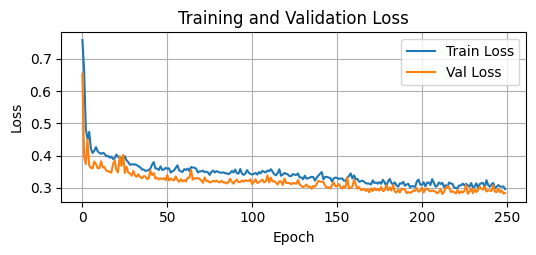

VALIDATION METRICS
ALS Denormalization dn = tensor * std + µ
 	µ: 	28.35m
 	std: 	5.72m
Metrics:
	MAE: 	3.55m
 	RMSE: 	4.69m
 	Bias: 	-0.18m
 	R2: 	0.74
----------------------------------------------
TEST METRICS
ALS Denormalization dn = tensor * std + µ
 	µ: 	28.35m
 	std: 	5.72m
Metrics:
	MAE: 	3.38m
 	RMSE: 	4.45m
 	Bias: 	-0.10m
 	R2: 	0.83
----------------------------------------------


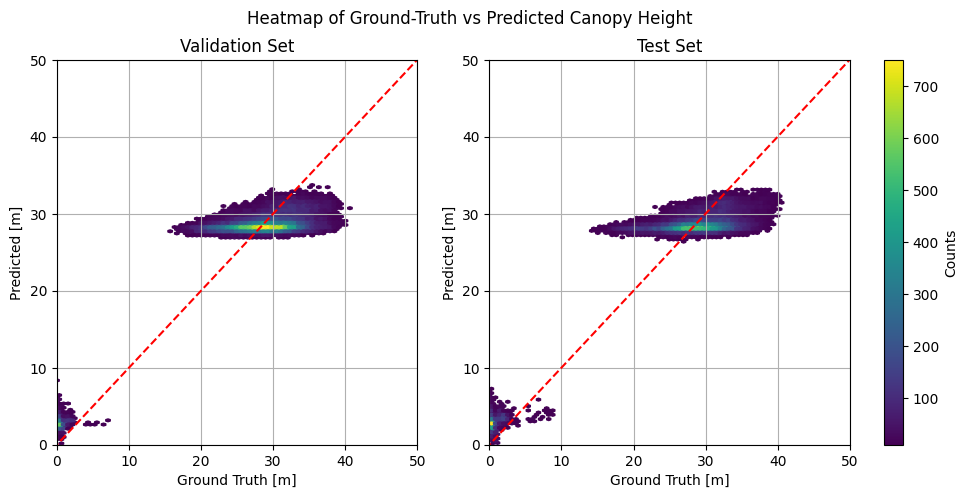

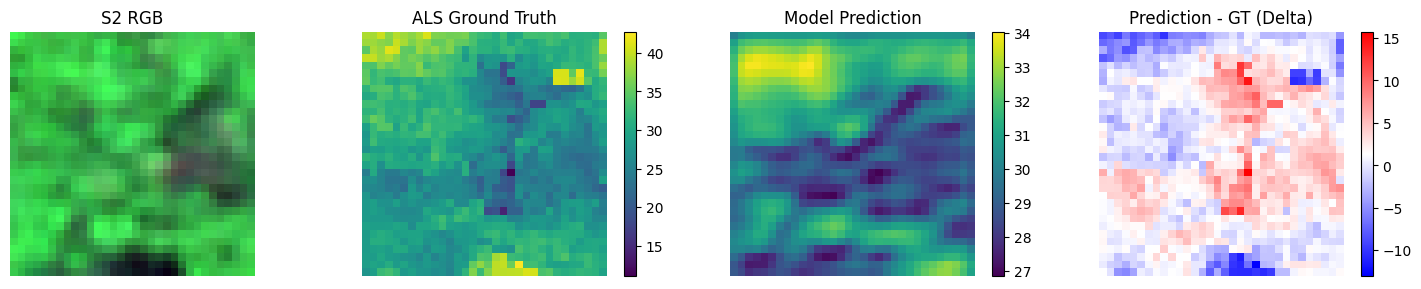

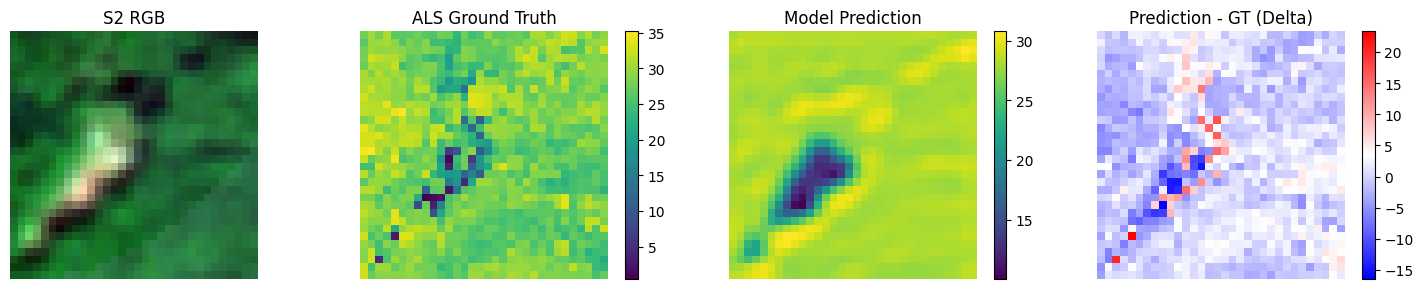

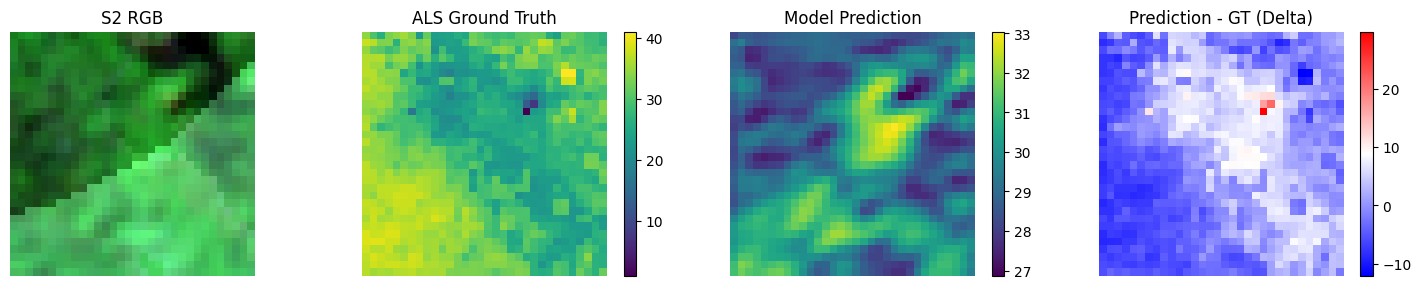

Configuration Parameters:
patch_size: 	32
num_bands: 	15
batch_size: 	64
lr: 	0.0017640065685665509
weight_decay: 	0.00010733588718244413
momentum: 	0.9342006313714166
epochs: 	250
huber_delta: 	0.7208103174228139
device: 	mps
edge_weight: 	1.002503154813983
-------------------------------
Model size: 		7.13 MB 
Number of parameters: 	1869761
-------------------------------
Evaluation report completed.


In [23]:
eval.plot_eval_report(train_losses, val_losses, model, val_loader,test_loader, json_path=ALS_NORM_PARAMS_JOINT, config=config)


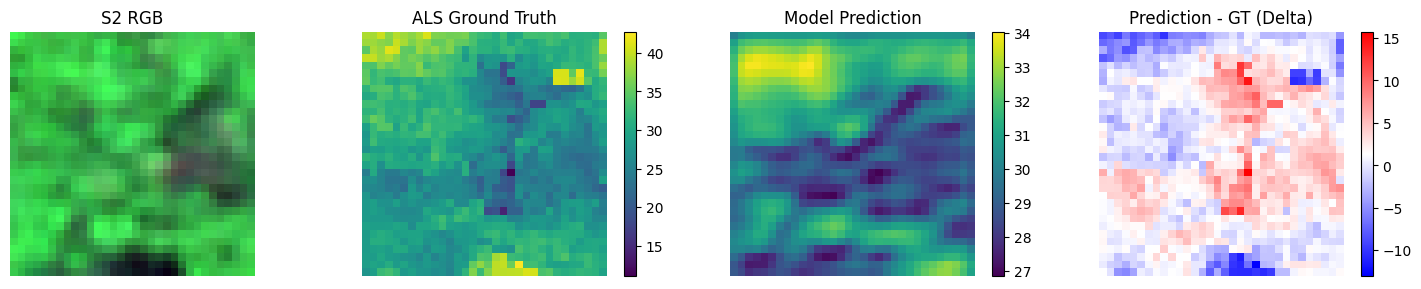

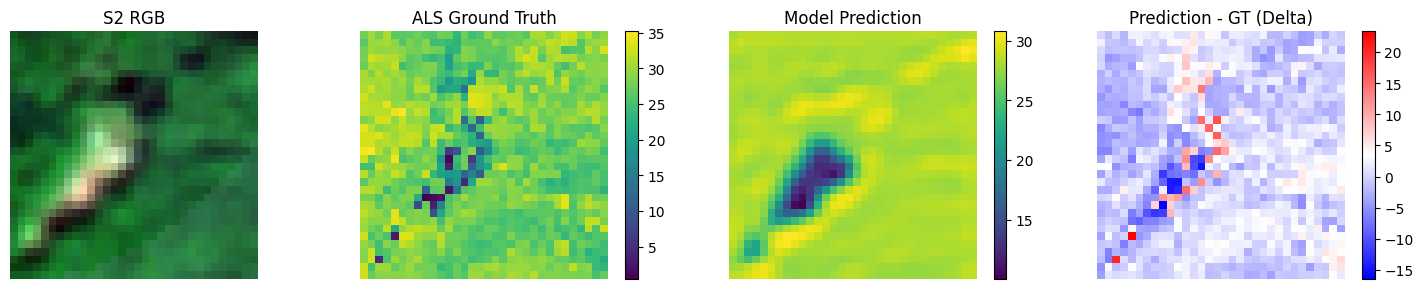

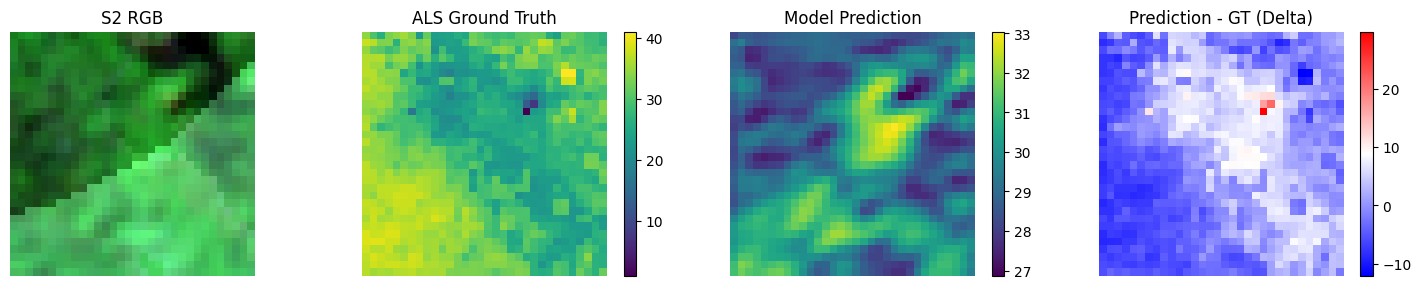

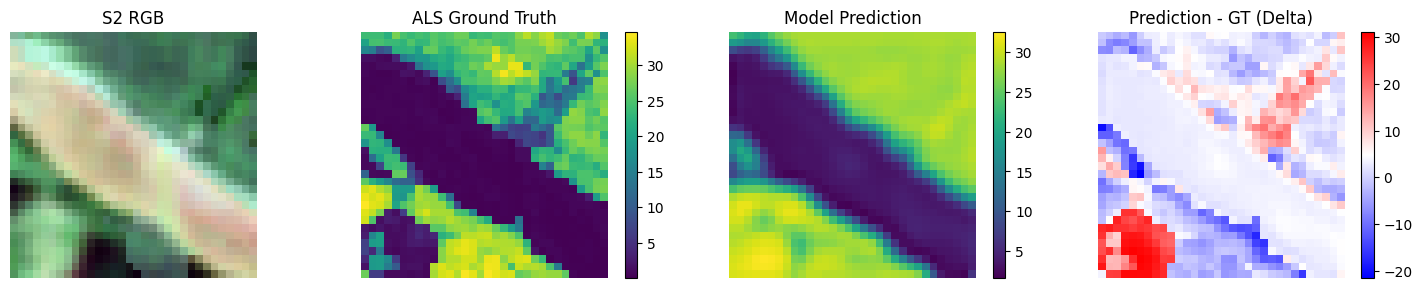

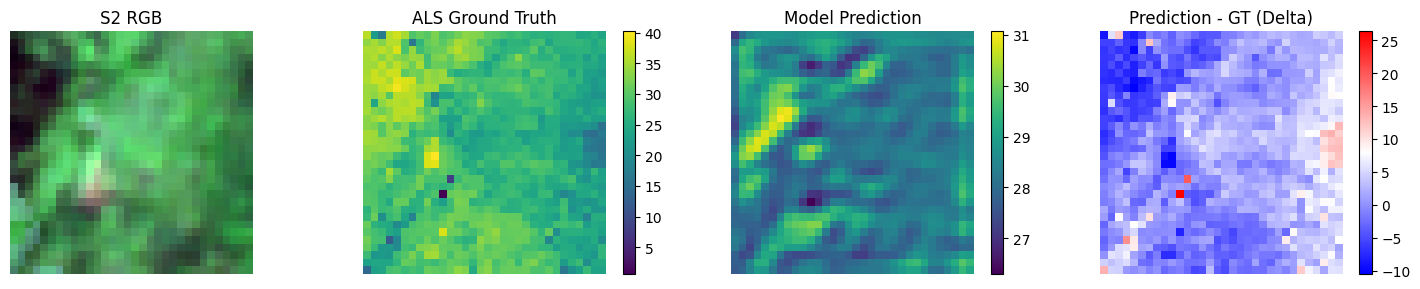

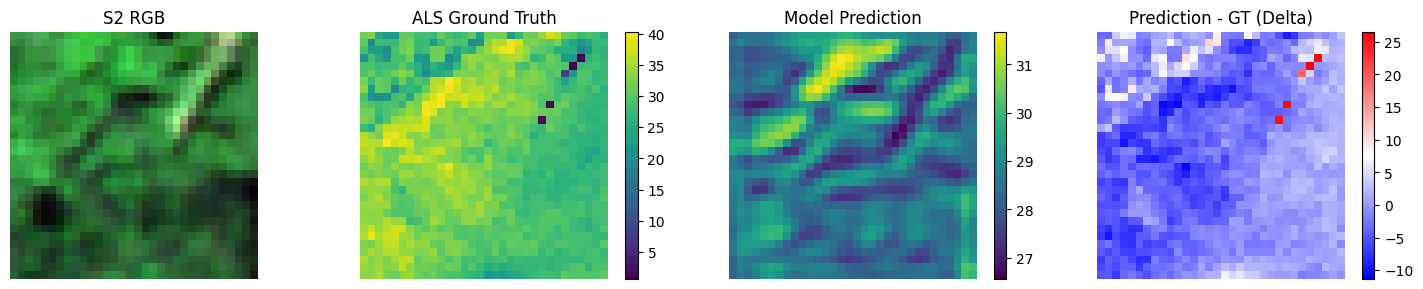

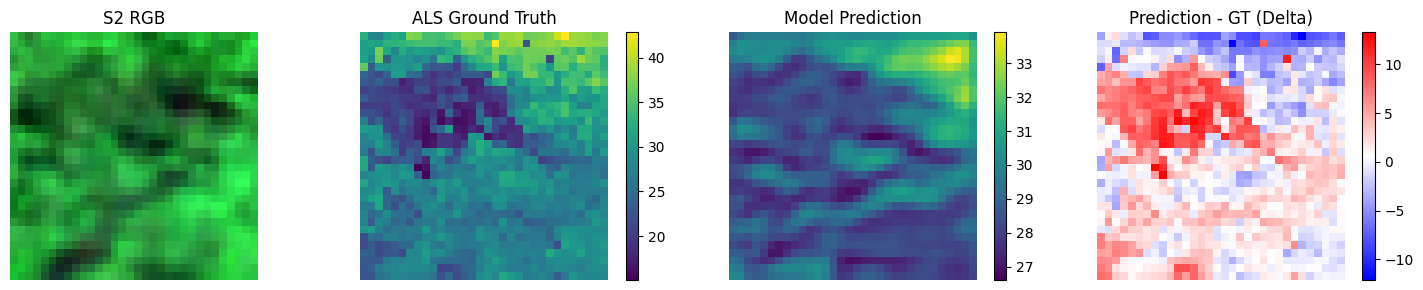

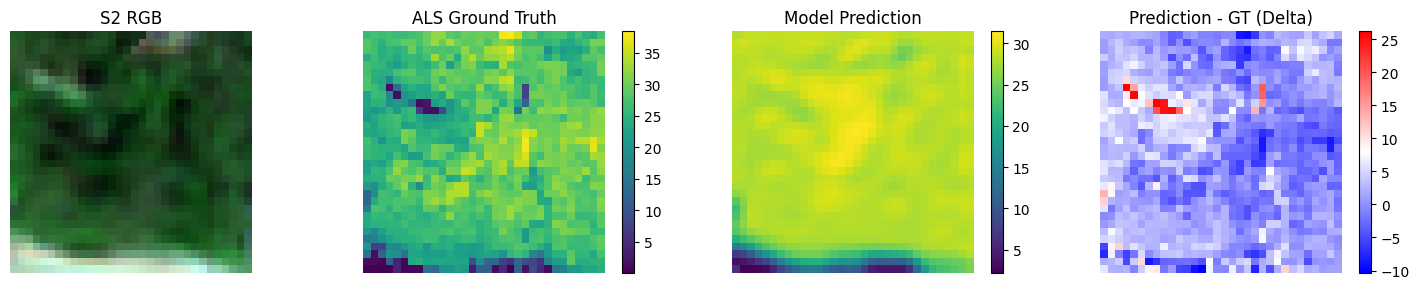

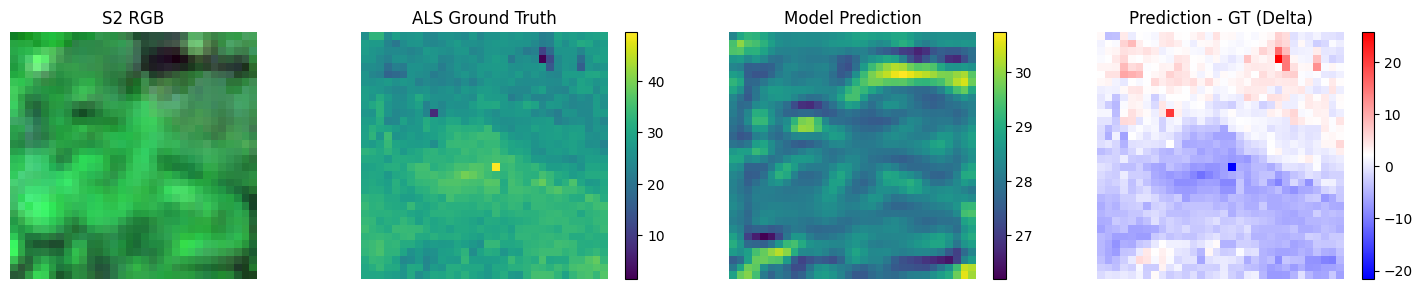

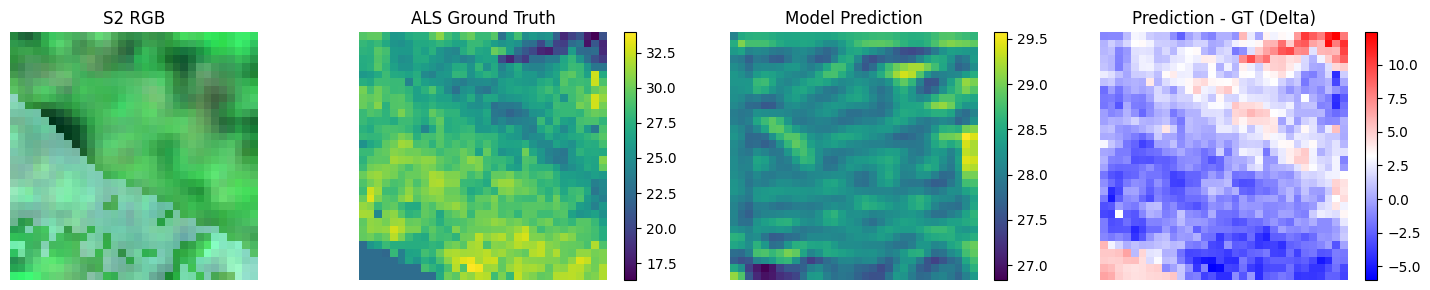

In [ ]:
eval.plot_real_pred_delta(model, val_loader, num_samples=10, device=config['device'],json_path=ALS_NORM_PARAMS_JOINT)

## Frequency based reweighting

### frequency based reweighting

In [97]:
def objective(trial):
    # Suggest hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [64])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    momentum = trial.suggest_float('momentum', 0.6, 0.99)
    huber_delta = trial.suggest_float('huber_delta', 0.7, 1.0)
    max_weight = trial.suggest_float('max_weight', 1.0, 5.0)
    tail_factor = trial.suggest_float('tail_factor', 1.0, 3.0)
    #edge_weight = trial.suggest_float('edge_weight', 1.0, 3.0)

    # Update config
    config.update({
        'batch_size': batch_size,
        'lr': lr,
        'weight_decay': weight_decay,
        'momentum': momentum,
        'huber_delta': huber_delta,
        'max_weight': max_weight,
        'tail_factor': tail_factor
        #'edge_weight': edge_weight
    })

    # Re-create loaders with new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    hist, bin_edges = train_dataset.__getdistr__()

    # Model, optimizer, loss
    model = UNet(config['num_bands']).to(config['device'])
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = frequency_weighted_huber_loss

    # Training loop (short for tuning)
    epochs = 30
    for epoch in range(epochs):
        model.train()
        for inputs, targets, mask in train_loader:
            inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets, mask, delta=huber_delta, hist=hist, bin_edges=bin_edges, max_weight=max_weight, tail_factor=tail_factor)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets, mask in val_loader:
                inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
                outputs = model(inputs)
                loss = criterion(outputs, targets, mask, delta=huber_delta, hist=hist, bin_edges=bin_edges,max_weight=max_weight, tail_factor=tail_factor)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=75)

print("Best parameters:")
print(study.best_params)
print(f"Best validation loss: {study.best_value:.4f}")

# Overview of all trials
df_trials = study.trials_dataframe()
df_trials = df_trials.sort_values('value', ascending=True)
df_trials.head()

[I 2025-07-22 14:28:11,380] A new study created in memory with name: no-name-6435517c-763e-415b-86a5-2cbc640d49f8


[I 2025-07-22 14:28:27,044] Trial 0 finished with value: 1.8195538947252723 and parameters: {'batch_size': 64, 'lr': 0.00042947042849983413, 'weight_decay': 0.001678591917362237, 'momentum': 0.6381954051657543, 'huber_delta': 0.959224870668114, 'max_weight': 4.657476131999173, 'tail_factor': 2.252257535045447}. Best is trial 0 with value: 1.8195538947252723.
[I 2025-07-22 14:28:42,377] Trial 1 finished with value: 3.6141144667214493 and parameters: {'batch_size': 64, 'lr': 0.00033028129623023926, 'weight_decay': 8.703580253239135e-05, 'momentum': 0.6899534331943191, 'huber_delta': 0.9406787976118975, 'max_weight': 1.0790087552135885, 'tail_factor': 1.2405244703225675}. Best is trial 0 with value: 1.8195538947252723.
[I 2025-07-22 14:28:57,684] Trial 2 finished with value: 2.8509745907977346 and parameters: {'batch_size': 64, 'lr': 0.002321099323278874, 'weight_decay': 1.1152934434451578e-05, 'momentum': 0.6546069286693934, 'huber_delta': 0.742187932825626, 'max_weight': 3.0508597888907

Best parameters:
{'batch_size': 64, 'lr': 0.0011152887162198123, 'weight_decay': 0.0004652585119396249, 'momentum': 0.7992142651669868, 'huber_delta': 0.9576578990913267, 'max_weight': 3.681679702150505, 'tail_factor': 2.969084257537658}
Best validation loss: 0.8562


,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_huber_delta,params_lr,params_max_weight,params_momentum,params_tail_factor,params_weight_decay,state
58,58,0.856203,2025-07-22 14:32:54.720704,2025-07-22 14:33:09.864085,0 days 00:00:15.143381,64,0.957658,0.001115,3.681680,0.799214,2.969084,0.000465,COMPLETE
70,70,1.467854,2025-07-22 14:33:30.954393,2025-07-22 14:33:46.218321,0 days 00:00:15.263928,64,0.865970,0.001017,4.530059,0.610813,2.676230,0.000164,COMPLETE
47,47,1.482132,2025-07-22 14:32:19.315964,2025-07-22 14:32:34.455161,0 days 00:00:15.139197,64,0.811769,0.000650,4.982037,0.617304,2.715838,0.000058,COMPLETE
65,65,1.616386,2025-07-22 14:33:13.269673,2025-07-22 14:33:28.484853,0 days 00:00:15.215180,64,0.831964,0.000711,4.784126,0.964030,2.898655,0.000478,COMPLETE
41,41,1.633756,2025-07-22 14:31:46.738923,2025-07-22 14:32:01.845354,0 days 00:00:15.106431,64,0.860640,0.001184,4.825562,0.604060,2.457118,0.002682,COMPLETE


In [106]:
# Central hyperparameter config
finetrainmode = False # not(pretrainmode)
config = {
    'patch_size': 32,
    'num_bands': 15,        # change based on input (13+1 for fmask, +1 for mask channel)
    'batch_size': 64,
    'lr': 1e-3,
    'weight_decay': 3e-4,
    'momentum': 0.9,
    'epochs': 300,
    'huber_delta': 1,
    'max_weight': 3.0,
    'tail_factor': 1.0,
    # 'edge_weight': 2.0,  # not used in final model
    'device':  'mps' if torch.backends.mps.is_available() else 'cpu'
}

#config.update(study.best_params)

model = UNet(config['num_bands']).to(config['device']) 
# load pretrained model if available as initialization
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
hist, bin_edges = train_dataset.__getdistr__()

if finetrainmode:

    print("Finetuning mode: Loading pretrained model...")

    PRETRAINED_MODEL_PATH = '../models/unet_7_pretrain.pth'
    #model.load_state_dict(torch.load(PRETRAINED_MODEL_PATH, map_location=config['device']))
    pretrained_dict = torch.load(PRETRAINED_MODEL_PATH, map_location=config['device'])
    model_dict = model.state_dict()

    # Filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

    # Overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 

    # Load the new state dict
    model.load_state_dict(model_dict)


criterion_nomask = nn.HuberLoss(delta=config['huber_delta'])
criterion = frequency_weighted_huber_loss  # Use custom masked Huber loss
# criterion = nn.MSELoss()  # or nn.L1Loss() for Mean Absolute
# Learning rate scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

train_losses, val_losses = [], []
nancounts = 0

for epoch in trange(config['epochs'], desc="Epochs"):
    model.train()
    train_loss = 0.0
    for inputs, targets, mask in train_loader:
        inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets, mask, hist=hist,bin_edges=bin_edges, delta=config['huber_delta'], max_weight=config['max_weight'], tail_factor=config['tail_factor'])
        loss.backward()
        #loss_nomask = criterion_nomask(outputs,targets)
        #if abs(loss-loss_nomask)>1e-3: print("Error in Loss Function, unless nan input fed in.")
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        # Count number of zeros in the mask tensor for this batch
        nancounts += (mask == 0).sum().item()

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, mask in val_loader:
            inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
            outputs = model(inputs)
            loss = criterion(outputs, targets, mask, delta=config['huber_delta'], hist=hist,bin_edges=bin_edges,max_weight=config['max_weight'], tail_factor=config['tail_factor'])
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if (epoch + 1) % 10 == 0 or epoch == config['epochs'] - 1:
        continue
        #print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        #print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    #print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
print("nancounts: ",nancounts)

Epochs: 100%|██████████| 300/300 [02:38<00:00,  1.90it/s]

nancounts:  0


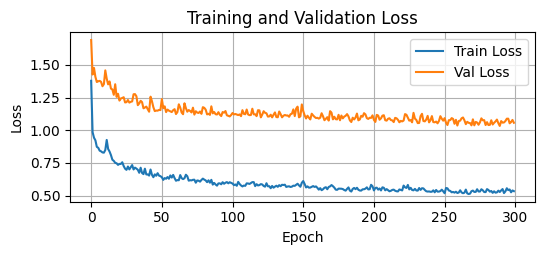

VALIDATION METRICS
ALS Denormalization dn = tensor * std + µ
 	µ: 	28.35m
 	std: 	5.72m
Metrics:
	MAE: 	4.38m
 	RMSE: 	5.59m
 	Bias: 	-0.26m
 	R2: 	0.67
----------------------------------------------
TEST METRICS
ALS Denormalization dn = tensor * std + µ
 	µ: 	28.35m
 	std: 	5.72m
Metrics:
	MAE: 	4.46m
 	RMSE: 	5.60m
 	Bias: 	0.02m
 	R2: 	0.76
----------------------------------------------


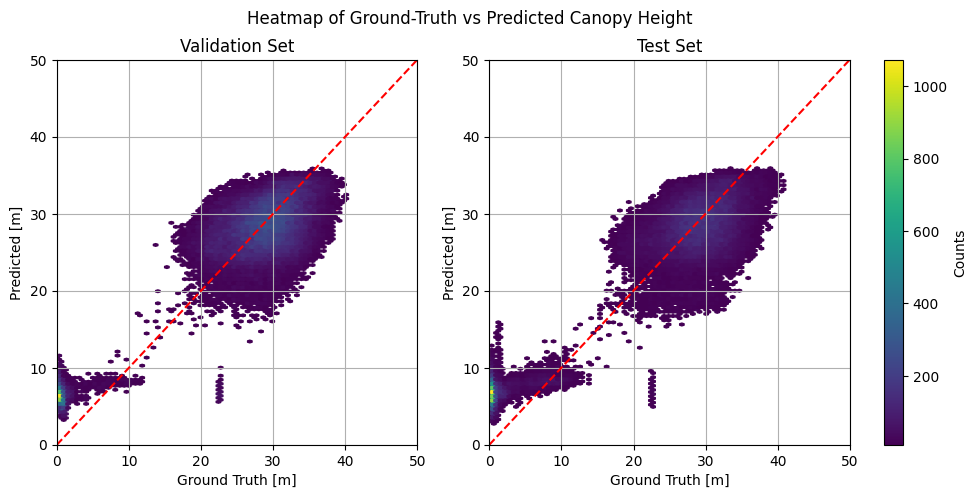

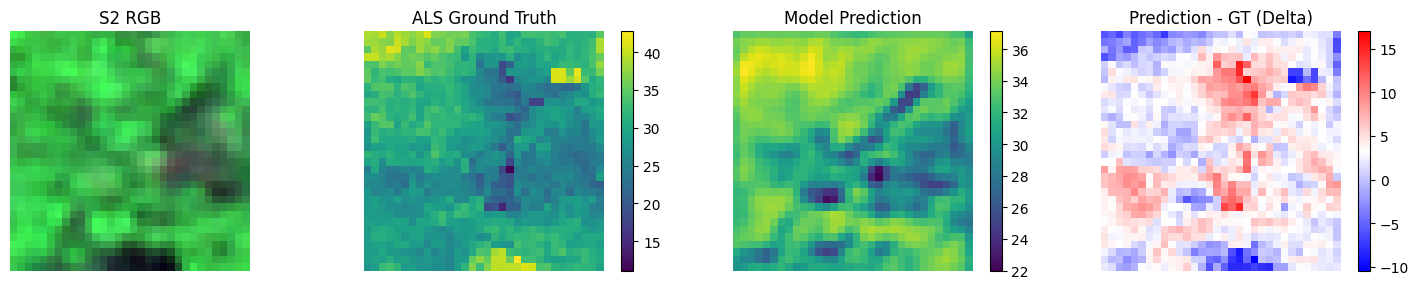

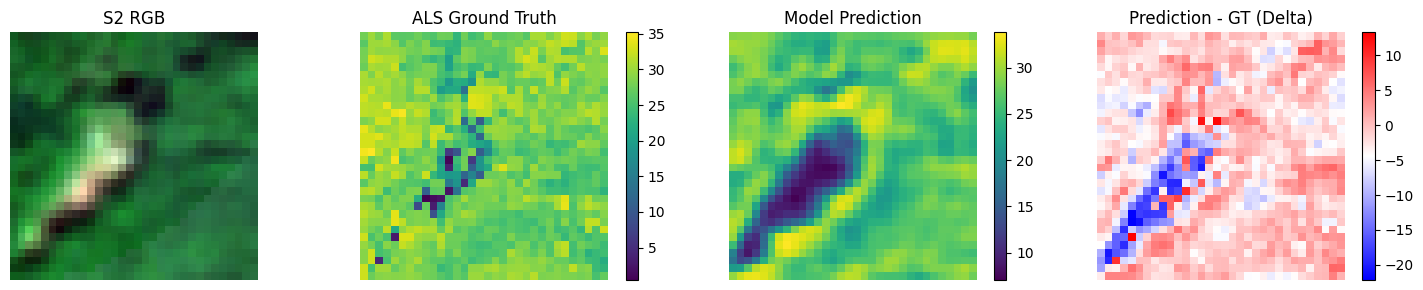

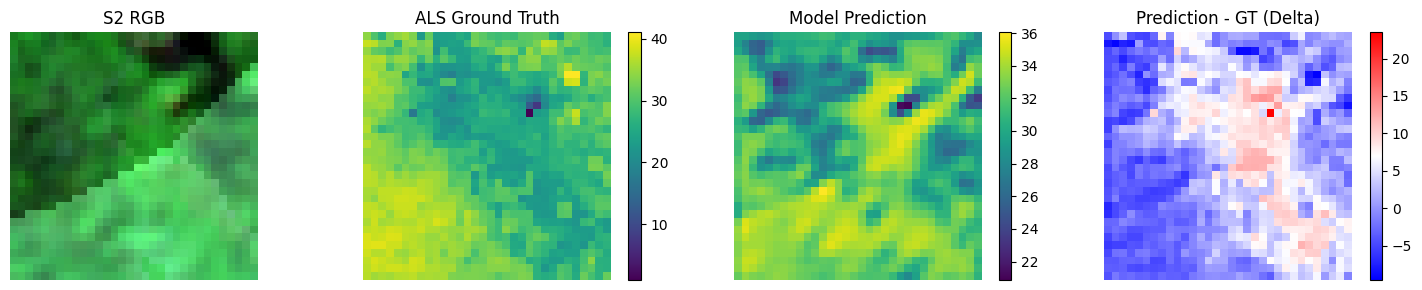

Configuration Parameters:
patch_size: 	32
num_bands: 	15
batch_size: 	64
lr: 	0.001
weight_decay: 	0.0003
momentum: 	0.9
epochs: 	300
huber_delta: 	1
max_weight: 	3.0
tail_factor: 	1.0
device: 	mps
-------------------------------
Model size: 		7.13 MB 
Number of parameters: 	1869761
-------------------------------
Evaluation report completed.


In [107]:
eval.plot_eval_report(train_losses, val_losses, model, val_loader, test_loader, json_path=ALS_NORM_PARAMS_JOINT, config=config)

### further ideas

weitere Ideen:
- train 1st site
- use weights as init, train with 2nd site 
- test with 2nd site 
--> if this retraining significantly improves performance, then data amount is bottleneck

---

- dropout parameter experiments 
- ML Perceptron mit mittlerem Pixel vergleichen

- Layer von sentinel auf verschiedenen ebenen des U-Nets einbringen (?)
- DEM als zusätzliche Input Layer (Sri has DEM)
---
Loss-Function engineering:
- frequency-based-reweighting
- **edge sensitive loss**
---
Learning of middle-features before learning CHM
- Forest(Y/N): U-Net + classification for ForestMask (cross-entropy-loss) Reference-Data: ForestMask
- **Leaf-Type (Y/N)** Classification: Dominant-Leaf-Type (Green-channel; December) Reference-Data: tbd 
- learn distribution of ALS (?)
--- 
- ViT vom Scratch trainieren 
- ViT classification for ForestMask (cross-entropy-loss) -> Use in Pretraining

---
- look for a pretrained Foundation Model 
- DIY "Foundation Model" with S2 for Bavaria 
